<a href="https://colab.research.google.com/github/hasantalib/NovaHACKS/blob/main/Copy_of_Autonomous_Nav_Agent_run_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt
from IPython import display

class QNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

In [ ]:
class StableDQNAgent:
    def __init__(self, state_dim, action_dim):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.memory = deque(maxlen=10000)
        self.gamma = 0.99
        self.epsilon = 1.0
        self.epsilon_decay = 0.998
        self.epsilon_min = 0.01
        self.batch_size = 128
        self.tau = 0.005

        self.policy_net = QNetwork(state_dim, action_dim)
        self.target_net = QNetwork(state_dim, action_dim)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=0.0005)
        self.criterion = nn.MSELoss()

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_dim)
        state_t = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            return torch.argmax(self.policy_net(state_t)).item()

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def train(self):
        if len(self.memory) < self.batch_size:
            return 0

        minibatch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*minibatch)

        states = torch.FloatTensor(np.array(states))
        actions = torch.LongTensor(actions).unsqueeze(1)
        rewards = torch.FloatTensor(rewards).unsqueeze(1)
        next_states = torch.FloatTensor(np.array(next_states))
        dones = torch.FloatTensor(dones).unsqueeze(1)

        current_q = self.policy_net(states).gather(1, actions)

        with torch.no_grad():
            next_q = self.target_net(next_states).max(1)[0].unsqueeze(1)
            target_q = rewards + (self.gamma * next_q * (1 - dones))

        loss = self.criterion(current_q, target_q)
        self.optimizer.zero_grad()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(self.policy_net.parameters(), max_norm=1.0)

        self.optimizer.step()

        for target_param, policy_param in zip(self.target_net.parameters(), self.policy_net.parameters()):
            target_param.data.copy_(self.tau * policy_param.data + (1.0 - self.tau) * target_param.data)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        return loss.item()

Episode: 0, Score: 25.0, Epsilon: 1.00
Episode: 20, Score: 13.0, Epsilon: 0.58
Episode: 40, Score: 44.0, Epsilon: 0.26
Episode: 60, Score: 259.0, Epsilon: 0.01
Episode: 80, Score: 333.0, Epsilon: 0.01
Episode: 100, Score: 102.0, Epsilon: 0.01
Episode: 120, Score: 102.0, Epsilon: 0.01
Episode: 140, Score: 109.0, Epsilon: 0.01
Episode: 160, Score: 121.0, Epsilon: 0.01
Episode: 180, Score: 132.0, Epsilon: 0.01
Episode: 200, Score: 130.0, Epsilon: 0.01
Episode: 220, Score: 152.0, Epsilon: 0.01
Episode: 240, Score: 500.0, Epsilon: 0.01
Episode: 260, Score: 255.0, Epsilon: 0.01
Episode: 280, Score: 500.0, Epsilon: 0.01
Episode: 300, Score: 369.0, Epsilon: 0.01
Episode: 320, Score: 118.0, Epsilon: 0.01
Episode: 340, Score: 120.0, Epsilon: 0.01
Episode: 360, Score: 132.0, Epsilon: 0.01
Episode: 380, Score: 500.0, Epsilon: 0.01
Episode: 400, Score: 135.0, Epsilon: 0.01
Episode: 420, Score: 500.0, Epsilon: 0.01
Episode: 440, Score: 213.0, Epsilon: 0.01
Episode: 460, Score: 500.0, Epsilon: 0.01
E

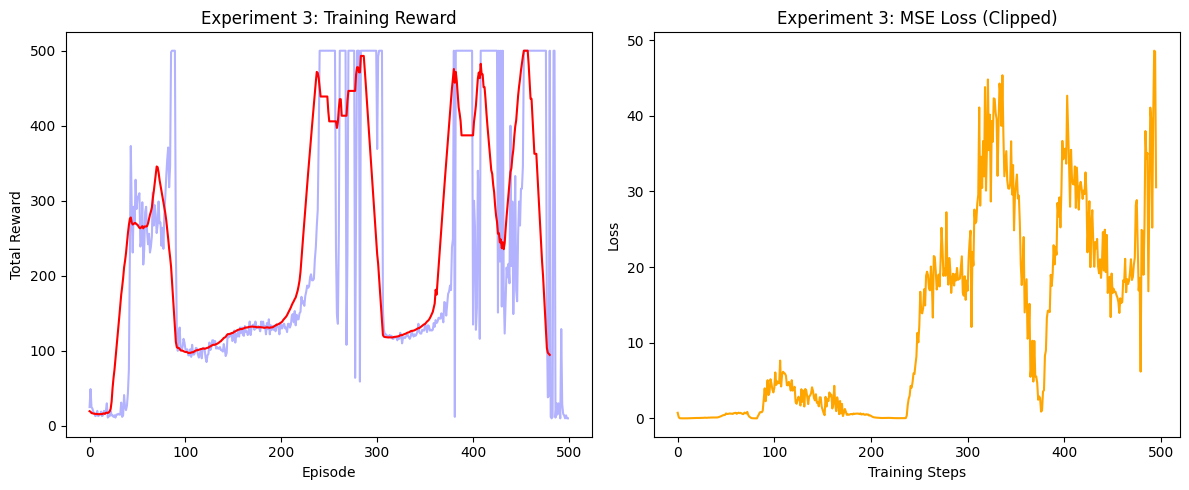

In [ ]:
env = gym.make("CartPole-v1")
agent = StableDQNAgent(env.observation_space.shape[0], env.action_space.n)
all_rewards = []
all_losses = []

for e in range(500):
    state, _ = env.reset()
    total_reward = 0
    ep_losses = []

    for time in range(500):
        action = agent.act(state)
        next_state, reward, done, truncated, _ = env.step(action)
        agent.remember(state, action, reward, next_state, done or truncated)
        state = next_state
        total_reward += reward

        loss = agent.train()
        if loss > 0: ep_losses.append(loss)
        if done or truncated: break

    all_rewards.append(total_reward)
    if ep_losses: all_losses.append(np.mean(ep_losses))

    if e % 20 == 0:
        print(f"Episode: {e}, Score: {total_reward}, Epsilon: {agent.epsilon:.2f}")

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(all_rewards, color='blue', alpha=0.3)
plt.plot(np.convolve(all_rewards, np.ones(20)/20, mode='valid'), color='red')
plt.title('Experiment 3: Training Reward')
plt.xlabel('Episode')
plt.ylabel('Total Reward')

plt.subplot(1, 2, 2)
plt.plot(all_losses, color='orange')
plt.title('Experiment 3: MSE Loss (Clipped)')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.tight_layout()
plt.show()

In [ ]:
# Run this in your Experiment 3 Colab
torch.save(agent.policy_net.state_dict(), 'stable_cartpole_dqn.pth')